In [10]:
#Importamos las librerias necesarias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Diccionario de nombres de países tomamos como referencia los paises ya analizados en trabajos previos
nombres_paises = {
    'AT': 'Austria',
    'BE': 'Bélgica',
    'CH': 'Suiza',
    'DE': 'Alemania',
    'DK': 'Dinamarca',
    'ES': 'España',
    'FI': 'Finlandia',
    'FR': 'Francia',
    'LU': 'Luxemburgo',
    'NL': 'Paises Bajos'
}

#Creamos una lista con los paises
paises_iso = list(nombres_paises.keys())

# Cargar archivo TSV
df_raw = pd.read_csv('Housing prices statisticals.tsv', sep='\t')

# Separamps y renombramos las columnas
df_raw[['Frecuencia', 'Indicator', 'Unit', 'Geo']] = df_raw['freq,indic,unit,geo\\TIME_PERIOD'].str.split(',', expand=True)
df_raw.drop(columns=['freq,indic,unit,geo\\TIME_PERIOD'], inplace=True)

# Convertimos a formato largo
df_melted = df_raw.melt(id_vars=['Geo'], var_name='Year', value_name='Price_Index')

# Extraemos el año de strings tipo '2005-Q1'
df_melted['Year'] = df_melted['Year'].astype(str).str.extract(r'(\d{4})')
df_melted.dropna(subset=['Year'], inplace=True)
df_melted['Year'] = df_melted['Year'].astype(int)

# Limpiamos Price_Index
df_melted['Price_Index'] = df_melted['Price_Index'].replace(':', pd.NA)
df_melted['Price_Index'] = pd.to_numeric(df_melted['Price_Index'], errors='coerce')
df_melted.dropna(subset=['Price_Index'], inplace=True)

# Filtramps los países y añadimos las etiquetas legibles
df_top = df_melted[df_melted['Geo'].isin(paises_iso)].copy()
df_top['Geo_label'] = df_top['Geo'].map(lambda x: f"{x} - {nombres_paises[x]}")

df_top = df_top[['Geo', 'Geo_label', 'Year', 'Price_Index']]

In [12]:
#ahora iniciamos la regresion simple por cada pais 
#Guardamos los resultados
resultados=[]
for geo, grupo in df_top.groupby('Geo_label'):
    X = grupo['Year'].values.reshape(-1,1)
    y = grupo['Price_Index'].values

    modelo = LinearRegression()
    modelo.fit(X,y)

    resultados.append({
        'Geo_label': geo,
        'Slope':modelo.coef_[0],
        'Intercept':modelo.intercept_,
        'R2':modelo.score(X,y)
    })
    
df_regresion = pd.DataFrame(resultados).sort_values(by='Slope', ascending=False)

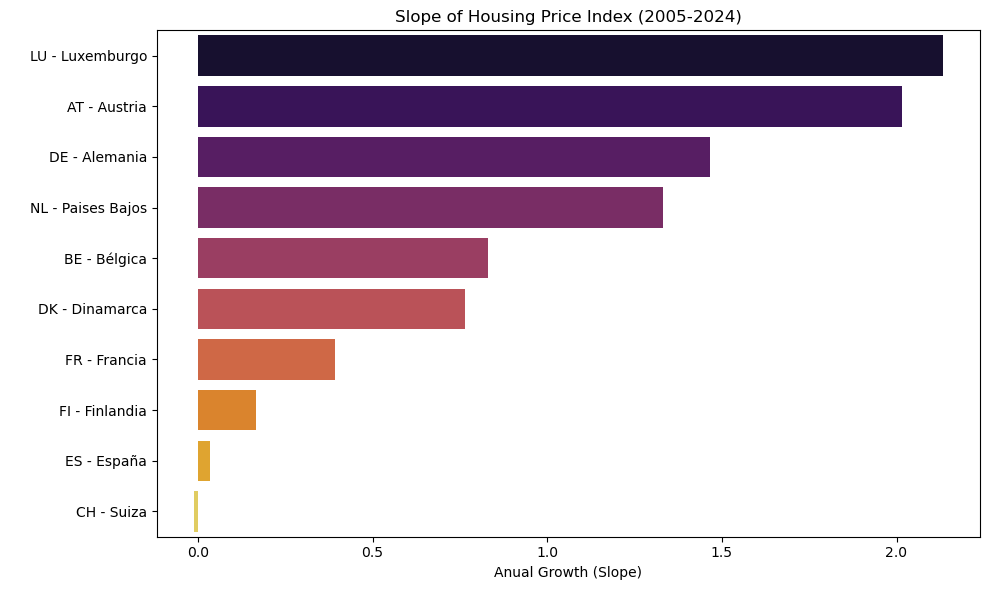

In [17]:
#Visualizamos el modelo
plt.figure(figsize=(10,6))
sns.barplot(
    data=df_regresion, 
    y='Geo_label', 
    x='Slope', 
    hue='Geo_label',
    legend = False,
    dodge = False,
    palette='inferno'
    )
plt.title('Slope of Housing Price Index (2005-2024)')
plt.xlabel('Anual Growth (Slope)')
plt.ylabel(' ')
plt.tight_layout()
plt.savefig('Slope of Housing Price Index (2005-2024).png')
plt.show()

Slope: -0.81
Intercept: 37.62
R²: 0.835


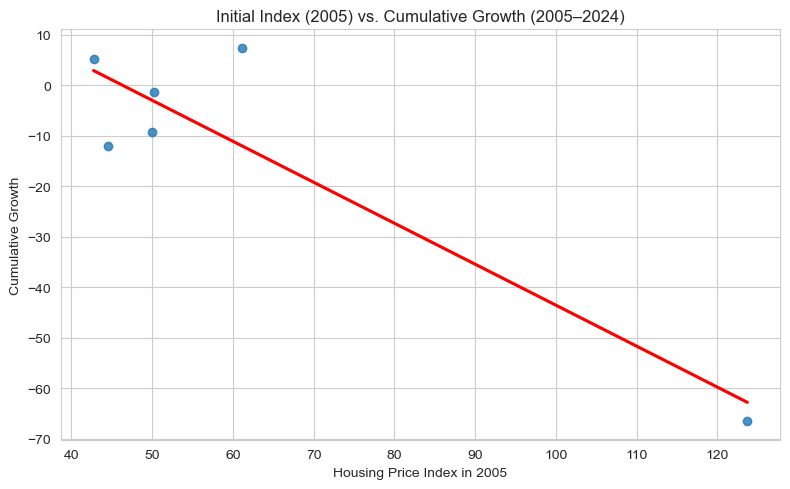

In [24]:
# Creamos tabla resumen
df_filtered = df_top[df_top['Year'].isin([2005, 2024])].copy()
df_filtered['Year'] = df_filtered['Year'].astype(str)

df_summary = (
    df_filtered
    .pivot_table(index='Geo_label', columns='Year', values='Price_Index', aggfunc='mean')
    .reset_index()
)

# Renombro las columnas si existen
if '2005' in df_summary.columns and '2024' in df_summary.columns:
    df_summary.rename(columns={'2005': 'Index_2005', '2024': 'Index_2024'}, inplace=True)
    df_summary['Cumulative_Growth'] = df_summary['Index_2024'] - df_summary['Index_2005']
    df_summary['Avg_Annual_Growth'] = df_summary['Cumulative_Growth'] / 19
    df_summary.dropna(subset=['Index_2005', 'Cumulative_Growth'], inplace=True)

    # Modelo
    X = df_summary[['Index_2005']]
    y = df_summary['Cumulative_Growth']
    modelo = LinearRegression().fit(X, y)

    print(f"Slope: {modelo.coef_[0]:.2f}")
    print(f"Intercept: {modelo.intercept_:.2f}")
    print(f"R²: {modelo.score(X, y):.3f}")

    # Visualización
    plt.figure(figsize=(8, 5))
    sns.regplot(data=df_summary, x='Index_2005', y='Cumulative_Growth', ci=None, line_kws={'color': 'red'})
    plt.title('Initial Index (2005) vs. Cumulative Growth (2005–2024)')
    plt.xlabel('Housing Price Index in 2005')
    plt.ylabel('Cumulative Growth')
    plt.tight_layout()
    plt.savefig('Initial Index (2005) vs. Cumulative Growth (2005–2024).png')
    plt.show()
else:
    print("⚠️ No se encontraron datos para ambos años: 2005 y 2024.")


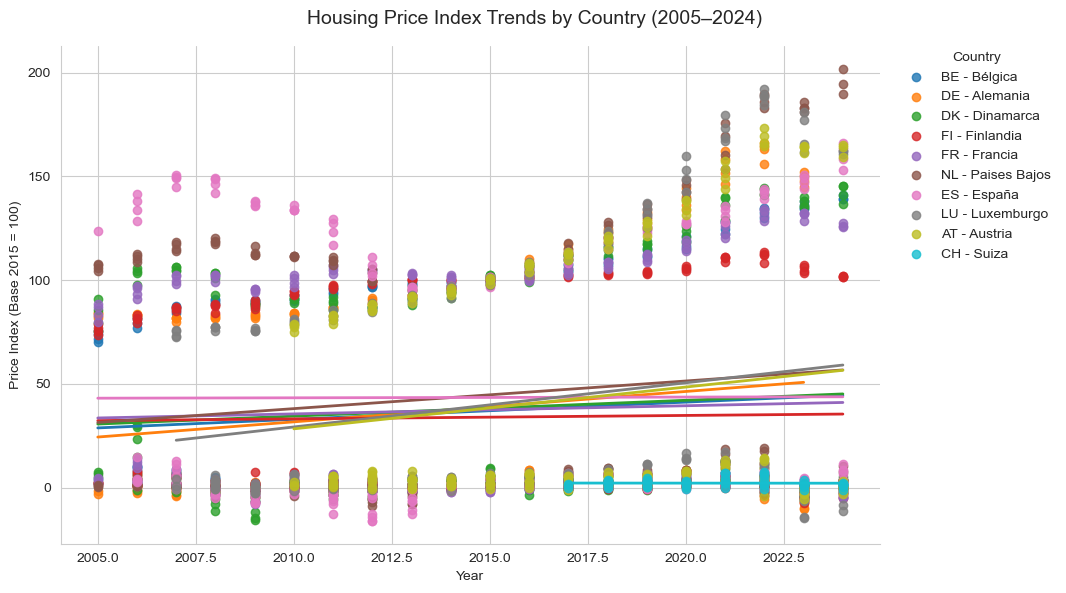

In [25]:
# Redibujamos el gráfico con control más preciso
sns.set_style('whitegrid')
g = sns.lmplot(
    data=df_top,
    x='Year',
    y='Price_Index',
    hue='Geo_label',
    ci=None,
    height=6,
    aspect=1.8,
    legend=False,
    line_kws={'linewidth': 2}
)

# Ajustamos los ejes y título
g.set_axis_labels('Year', 'Price Index (Base 2015 = 100)')
g.fig.suptitle('Housing Price Index Trends by Country (2005–2024)', fontsize=14)

# Movemos la leyenda fuera del gráfico para mejor visualizacion
plt.legend(
    title='Country',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0,
    frameon=False
)

plt.tight_layout()
plt.savefig('Housing Price Index Trends by Country (2005–2024).png')
plt.show()


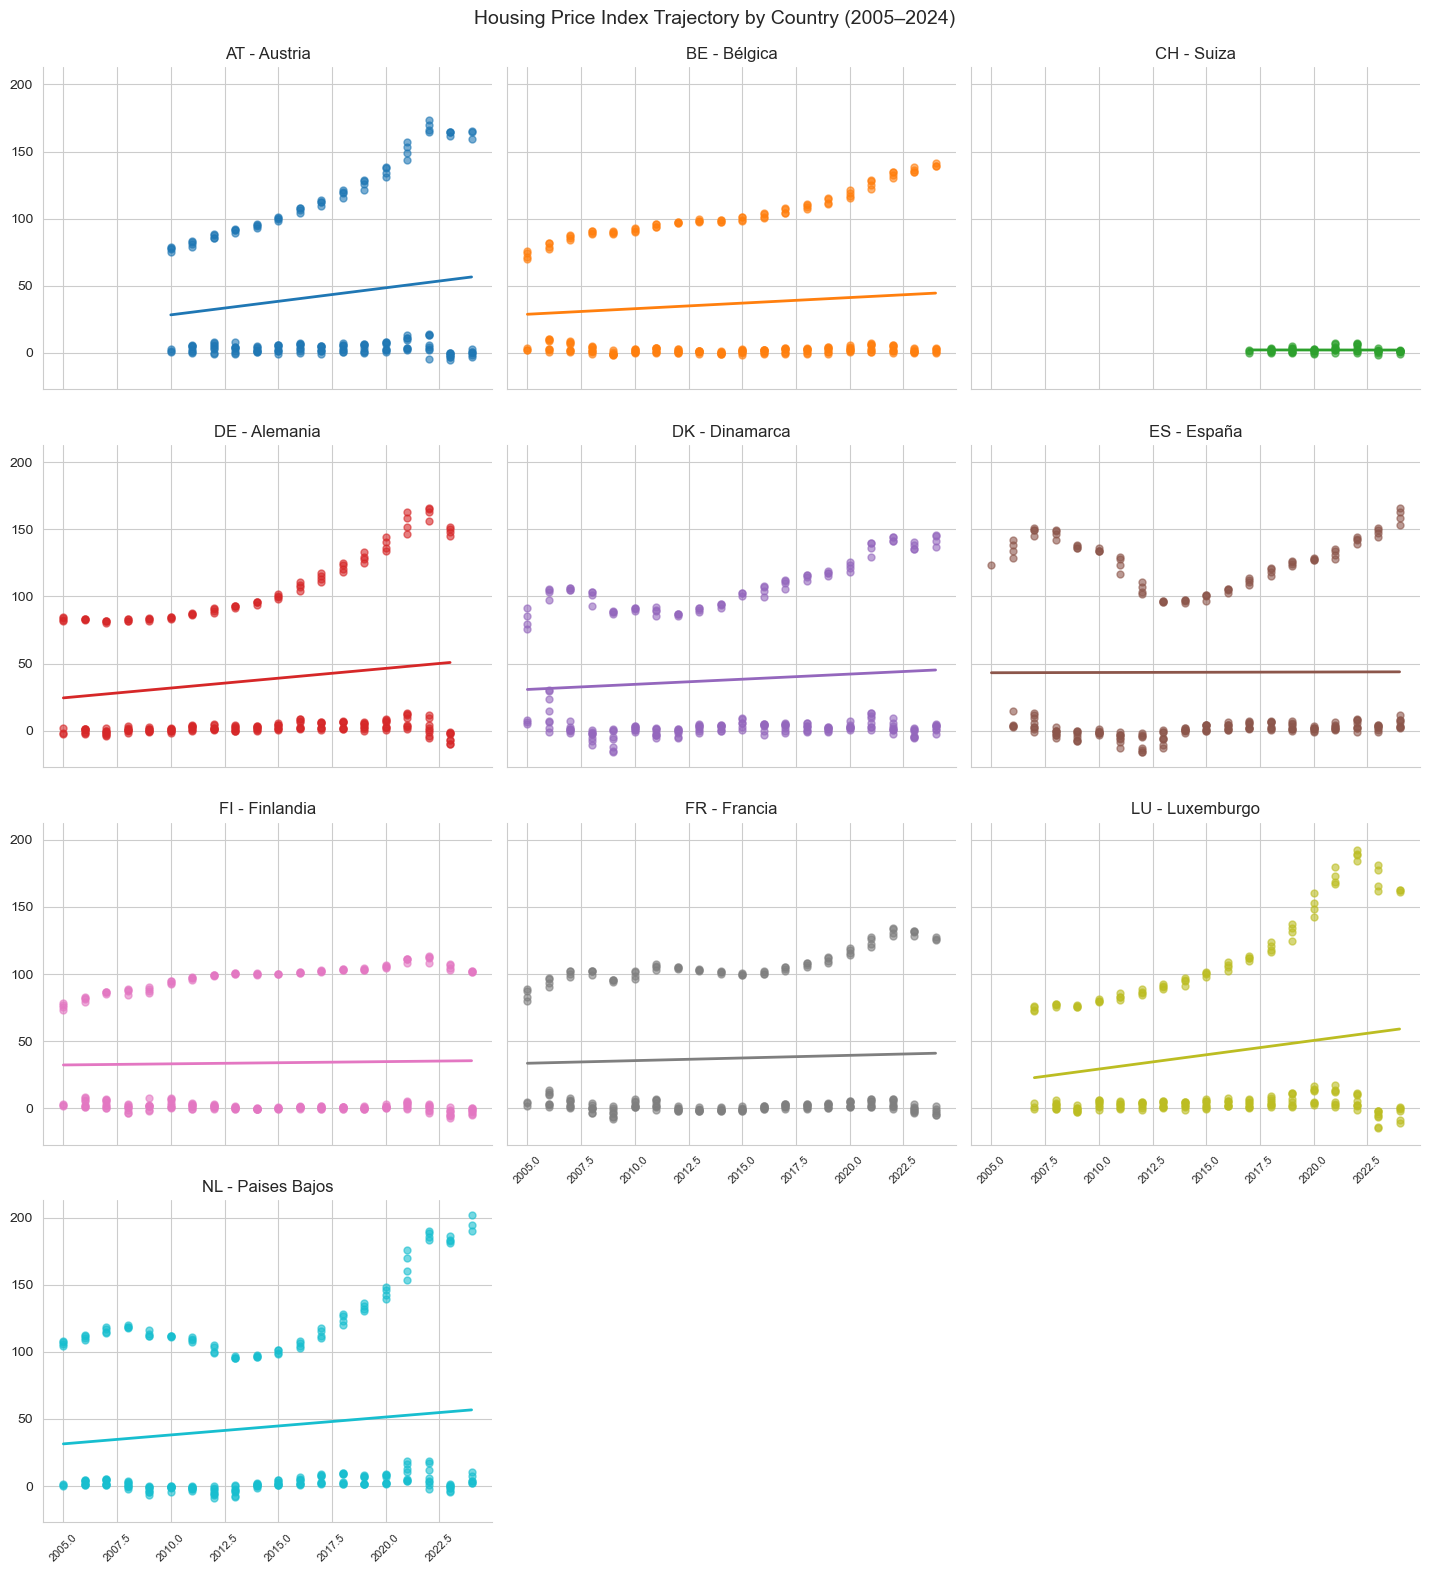

In [41]:
#ya las librerias necesarias estan instaladas e importadas

# Estilo visual limpio
sns.set_style('whitegrid')

#creo la lista de paises, paleta y les asigno color
paises = sorted(df_top['Geo_label'].unique())
paleta = sns.color_palette('tab10', n_colors=len(paises))
colores_por_pais = dict(zip(paises,paleta))

#creo los subgraficos manualmente
g = sns.FacetGrid(
    df_top,
    col="Geo_label",
    col_wrap=3,
    height=4,
    aspect=1.2,
    sharex=True,
    sharey=True
)

#procedemos a dibujar los puntos y las lineas por cada pais
for ax, (geo_label, data) in zip(g.axes.flatten(), df_top.groupby('Geo_label')):
    color = colores_por_pais[geo_label]
    sns.regplot(
        data=data,
        x='Year',
        y='Price_Index',
        ci=None,
        line_kws={'color':color, 'linewidth':2},
        scatter_kws={'color':color, 'alpha':0.6, 's':25},
        ax=ax
    )
    ax.set_title(geo_label)
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Rotar etiquetas del eje X para visibilidad
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_fontsize(8)
    
# Títulos globales
g.fig.subplots_adjust(top=0.93)
g.fig.suptitle('Housing Price Index Trajectory by Country (2005–2024)\n', fontsize=14)
print('\n')
plt.tight_layout()
plt.savefig('Housing Price Index Trajectory by Country (2005–2024) separeted-graphics.png')
plt.show()